# Exercise with A/B Testing

### Prompt

Let’s imagine you work on the For You Page at TikTok. Your team decides that instead of a heart button, they want to change it to star hoping that it will lead to a higher engagement/like rate. The product manager told you that the current conversion rate is about 6% on average throughout the year, and that the team would be happy with an increase of 3%, meaning that the new design will be considered a success if it raises the engagement rate to 9%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of the user base users.

In [1]:
# Packages imports
import numpy as np
import pandas as pd

# probability distributions & statistical functions
import scipy.stats as stats
# estimating statistical models
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
import seaborn as sns

#rounding function
from math import ceil

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

sns.set()


### Sample Size Calculation

In [2]:
# Calculate effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.06,0.09)
print(effect_size)

-0.11445118168989943


In [4]:
# Calculate sample size needed
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8,
    alpha=0.05,
    ratio=1)

required_n = ceil(required_n)
print(required_n)

1199


### Collecting and preparing the data

In [7]:
# Load the tiktok_data.csv into a dataframe
df = pd.read_csv("data/tiktok_data.csv")



In [8]:
# Get the info of the dataframe
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275781 entries, 0 to 275780
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    275781 non-null  int64 
 1   timestamp  275781 non-null  object
 2   group      275781 non-null  object
 3   button     275781 non-null  object
 4   liked      275781 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 10.5+ MB


In [9]:
# Check that no users have been sampled multiple times 
session_counts = df['user_id'].value_counts()
multi_users = session_counts[session_counts > 1].count()
print(multi_users)


3453


In [10]:
# If there are users who have been sampled multiple times, remove them from the dataframe
print(df.shape)
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(df.shape)


(275781, 5)
(268875, 5)


#### Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [11]:
# Perform simple random sampling to split the data into control and treatment
control_sample = df[df['group'] == 'control'].sample(n = 4720, random_state = 444)
treatment_sample = df[df['group'] == 'treatment'].sample(n = 4720, random_state = 444)
control_sample.head()


,user_id,timestamp,group,button,liked
184721,775113,2017-01-05 3:50:46,control,heart,0
23649,693666,2017-01-08 22:15:44,control,heart,0
17611,841336,2017-01-08 3:03:58,control,heart,0
182034,925455,2017-01-14 1:59:15,control,heart,0
70920,802394,2017-01-09 9:33:28,control,heart,0


In [12]:
# Create one table called ab_test that has both the cleaned control and treatment data
ab_test = pd.concat([control_sample, treatment_sample], axis = 0)
ab_test.reset_index(drop = True, inplace = True)
ab_test


,user_id,timestamp,group,button,liked
0,775113,2017-01-05 3:50:46,control,heart,0
1,693666,2017-01-08 22:15:44,control,heart,0
2,841336,2017-01-08 3:03:58,control,heart,0
3,925455,2017-01-14 1:59:15,control,heart,0
4,802394,2017-01-09 9:33:28,control,heart,0
...,...,...,...,...,...
9435,702455,2017-01-24 5:55:30,treatment,star,0
9436,655694,2017-01-21 2:59:11,treatment,star,0
9437,786090,2017-01-15 3:02:16,treatment,star,0
9438,907867,2017-01-15 11:05:07,treatment,star,0


In [13]:
# Count the test groups to make sure that they're balanced 
ab_test['group'].value_counts()


control      4720
treatment    4720
Name: group, dtype: int64

### Analysis Visualization

In [14]:
# Find the like rate by group
summary_stats = ab_test.groupby('group')['liked'].agg(['mean', 'std', 'sem', 'sum', 'count'])
summary_stats = summary_stats.reset_index()
summary_stats

# Find the Std. deviation of the proportion


# Find the Std. error of the proportion (std / sqrt(n))


# Calculate the final like rate


,group,mean,std,sem,sum,count
0,control,0.117585,0.322150,0.004689,555,4720
1,treatment,0.126059,0.331951,0.004832,595,4720


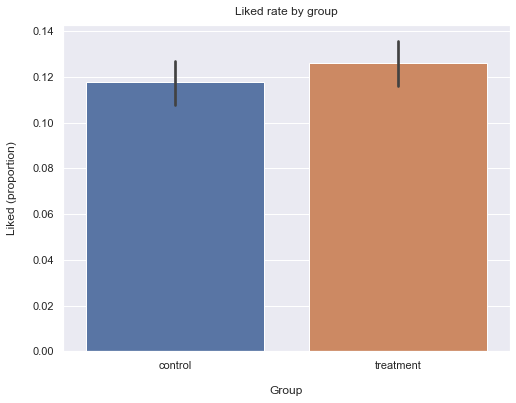

In [15]:
# Plot the like rate by group on a bar plot
plt.figure(figsize=(8,6))
sns.barplot(x=ab_test['group'], y=ab_test['liked'])

plt.title('Liked rate by group', pad=10)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Liked (proportion)', labelpad=15);


### Testing for Stat Sig

In [17]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group'] == 'control']['liked']
treatment_results = ab_test[ab_test['group'] == 'treatment']['liked']

# Get the like count for both control and treatment groups
control_likes = control_results.sum()
treatment_likes = treatment_results.sum()

# Get the number of samples in both groups
control_size = control_results.count()
treatment_size = treatment_results.count()

# Sum up the number of successes (likes) in both groups
successes = [control_likes, treatment_likes]

In [18]:
# Find the z statistic and p value for proportions based on normal ztest
z_stat, pval = proportions_ztest(
    successes, 
    nobs=nobs) 
# Find the confidence intervals for each test group

(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05) #confidence interval for a binomial proportion

In [19]:
# print z statistic
print(f'z statistic: {z_stat:.2f}')
# print p-value
print(f'p-value: {pval:.6f}')
# print ci 95% for control group
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
# print ci 95% for treatment group
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')


z statistic: -1.26
p-value: 0.208141
ci 95% for control group: [0.108, 0.127]
ci 95% for treatment group: [0.117, 0.136]


### Were the results signficant? 

### What would you advise the engineering team to do moving forward?